In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, Point
import pyproj
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline


bsas_map = gpd.read_file('../gopa_data/barrios-ciudad')


In [2]:
df_corners = pd.read_csv('../raw_data/fourcorners.csv', ',')
epsg = 'epsg:3857'
geometry = [Point(xy) for xy in zip(df_corners['lon'], df_corners['lat'])]
geo_df_corners = gpd.GeoDataFrame(df_corners, crs = epsg, geometry = geometry)
geo_df_corners

,dot,lat,lon,geometry
0,A,-34.534599,-58.531942,POINT (-58.53194 -34.53460)
1,B,-34.534599,-58.334982,POINT (-58.33498 -34.53460)
2,C,-34.705557,-58.334982,POINT (-58.33498 -34.70556)
3,D,-34.705557,-58.531942,POINT (-58.53194 -34.70556)


In [41]:
# rows = 10
# columns = 5
# x=-58.425
# y= -34.55

def row_column(x, y, columns=20, rows=20):
    nw_lat = geo_df_corners.lat[0]
    nw_lon = geo_df_corners.lon[0]
    ne_lat = geo_df_corners.lat[1]
    ne_lon = geo_df_corners.lon[1]
    se_lat = geo_df_corners.lat[2]
    se_lon = geo_df_corners.lon[2]    
    sw_lat = geo_df_corners.lat[3]
    sw_lon = geo_df_corners.lon[3]

    lat_dist_total = abs(nw_lat - sw_lat)
    lon_dist_total = abs(se_lon - sw_lon)

    lat_dist_ind = lat_dist_total/rows
    lon_dist_ind = lon_dist_total/columns

    ranges_columns = []
    ranges_rows = []


    for i in range(columns+1):
        ranges_columns.append(sw_lon+(lon_dist_ind*i))
    for j in range(rows+1):
        ranges_rows.append(sw_lat+(lat_dist_ind*j))

    for i in ranges_columns:
        if abs(x) > abs(i):
            column = ranges_columns.index(i)
            break

    for i in ranges_rows:
        if abs(y) > abs(i):
            row = ranges_rows.index(i)
            break

    return column, row



row_column(x=-58.415, y= -34.700, columns=20, rows=20)  

(12, 1)

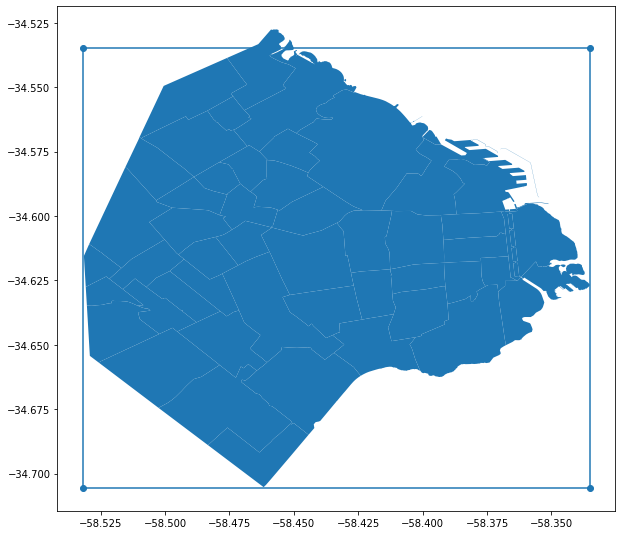

In [12]:
fig,ax = plt.subplots(figsize = (10,10))
bsas_map.plot(ax=ax)
geo_df_corners.plot(ax=ax)
x_values = [geo_df_corners.lon[0], geo_df_corners.lon[1], geo_df_corners.lon[2], geo_df_corners.lon[3], geo_df_corners.lon[3], geo_df_corners.lon[0]]
y_values = [geo_df_corners.lat[0], geo_df_corners.lat[1], geo_df_corners.lat[2], geo_df_corners.lat[3], geo_df_corners.lat[3], geo_df_corners.lat[0]]
plt.plot(x_values,y_values)

In [26]:
import numpy as np

def grid_coordinates(geo_df_corners, columns, rows):
    nw_lat = geo_df_corners.lat[0]
    nw_lon = geo_df_corners.lon[0]
    ne_lat = geo_df_corners.lat[1]
    ne_lon = geo_df_corners.lon[1]
    se_lat = geo_df_corners.lat[2]
    se_lon = geo_df_corners.lon[2]    
    sw_lat = geo_df_corners.lat[3]
    sw_lon = geo_df_corners.lon[3]

    lat_dist = abs(nw_lat - sw_lat)
    lon_dist = abs(se_lon - sw_lon)

    list_columns = np.linspace(nw_lon,ne_lon,columns)
    list_rows = np.linspace(nw_lat,sw_lat,rows)

    data_coordinates = {'longitude':[], 'latitude':[]}

    for row in list_rows:
        for column in list_columns:
            data_coordinates['longitude'].append(column)
            data_coordinates['latitude'].append(row)
    
    return data_coordinates

In [29]:
data_coordinates = grid_coordinates(geo_df_corners, columns = 20, rows = 20)

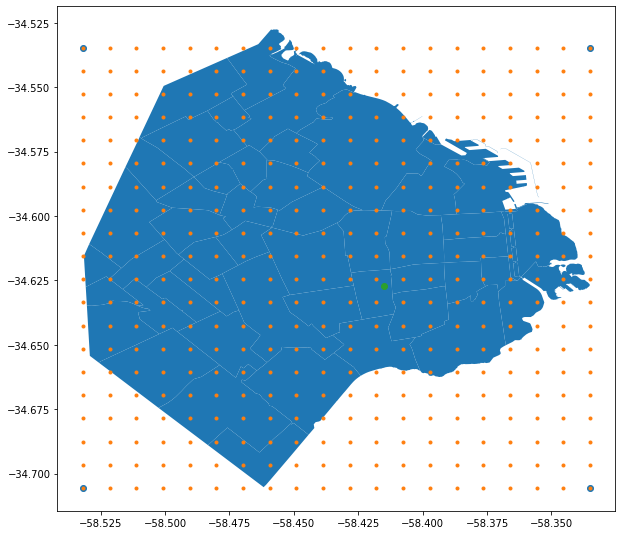

In [42]:
fig,ax = plt.subplots(figsize = (10,10))
bsas_map.plot(ax=ax)
geo_df_corners.plot(ax=ax)
x_values = data_coordinates['longitude']
y_values = data_coordinates['latitude']
plt.scatter(x_values,y_values, marker= '.')
plt.scatter(-58.415, -34.627)




In [ ]:
df = pd.read_csv('fourcorners.csv', ',')
epsg = 'epsg:3857'
df.head()

In [ ]:
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
geometry

In [ ]:
geo_df = gpd.GeoDataFrame(df,
                         crs = epsg, 
                         geometry = geometry)
geo_df

In [ ]:
fig,ax = plt.subplots(figsize = (10,10))
bsas_map.plot(ax=ax, color='grey')
geo_df.plot(ax=ax, markersize=20, alpha=0.4, color='blue')

In [ ]:
# Set up projections
p_ll = pyproj.Proj('epsg:4326') # epsg mundo
p_mt = pyproj.Proj('EPSG:3857') # epsg argentinta


In [ ]:
import shapely
sw = shapely.geometry.Point((-58.538143, -34.705557))
ne = shapely.geometry.Point((-58.350345, -34.532787))

stepsize = 500 # 500 m grid step size

In [ ]:
# Project corners to target projection
transformed_sw = pyproj.transform(p_ll, p_mt, sw.x, sw.y) # Transform NW point to 22177
transformed_ne = pyproj.transform(p_ll, p_mt, ne.x, ne.y) # .. same for SE

In [ ]:
# Iterate over 2D area
gridpoints = []
x = transformed_sw[0]
while x < transformed_ne[0]:
    y = transformed_sw[1]
    while y < transformed_ne[1]:
        p = shapely.geometry.Point(pyproj.transform(p_mt, p_ll, x, y))
        gridpoints.append(p)
        y += stepsize
    x += stepsize

In [ ]:
import csv

with open('testoutbsas.csv', 'w') as of:
    of.write('lon,lat\n')
    for p in gridpoints:
        of.write('{:f},{:f}\n'.format(p.x, p.y))

In [ ]:
df_coords = pd.read_csv('testoutbsas.csv')
epsg = 'epsg:3857'
df_coords

In [ ]:
gdf = gpd.GeoDataFrame(
    df_coords, geometry=gpd.points_from_xy(df_coords.lon, df_coords.lat))

In [ ]:
gdf

In [ ]:
fig,ax = plt.subplots(figsize = (20,20))
bsas_map.plot(ax=ax, color='grey')
gdf.plot(ax=ax, markersize=5, alpha=0.4, color='blue')

In [ ]:
import numpy as np


In [ ]:
data = pd.read_json('backupPretty.json')
data

In [ ]:
data = data.T
data.head()

In [ ]:
data = data.drop(columns = ['user_longitude', 'user_latitude', '__collections__'])
data

In [ ]:
data = data[['search_longitude', 'search_latitude', 'arrive', 'leave','search_method', 'timestamp', 'uid']]

In [ ]:
data.reset_index(level=0, inplace=True) 

In [ ]:
data.drop(columns="index", inplace=True)

In [ ]:
data['search_method'] = data['search_method'].convert_dtypes()

In [ ]:
data['search_method'].dtypes

In [ ]:
data["search_method"]

In [ ]:
data = data[data.search_method != 'startup']
data.head()

In [ ]:
gpd_data = gpd.GeoDataFrame(data,
                         crs = epsg, 
                         geometry = gpd.points_from_xy(data.search_longitude, data.search_latitude))
gpd_data

In [ ]:
fig,ax = plt.subplots(figsize = (20,20))
bsas_map.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax, markersize=5, color='black')
gpd_data.plot(ax=ax, markersize=5, color='red')
ax.set_xlim([-58.550, -58.325])
ax.set_ylim([-34.700, -34.525])


In [ ]:
grid_coordinates_gdf = gdf.copy()

In [ ]:
grid_coordinates_gdf['y'] = grid_coordinates_gdf['lat']
grid_coordinates_gdf['x'] = grid_coordinates_gdf['lon']
grid_coordinates_gdf.drop(columns = ['lat', 'lon'], inplace=True)

In [ ]:
grid_coordinates_gdf

In [ ]:
def coord_to_numsx(x):
    initial_x = 58.538143
    new_x = initial_x + x
    return new_x
    

def coord_to_numsy(y): 
    initial_y = 34.705557
    new_y = initial_y + y
    return new_y
    


In [ ]:
grid_coordinates_gdf["new_x"] = grid_coordinates_gdf["x"].map(coord_to_numsx)
grid_coordinates_gdf["new_y"] = grid_coordinates_gdf["y"].map(coord_to_numsy)


In [ ]:
grid_coordinates_gdf = pd.DataFrame(grid_coordinates_gdf)

grid_coordinates_gdf

In [ ]:
# fig,ax = plt.subplots(figsize = (20,20))
# grid_coordinates_gdf.plot(ax=ax, color='black', x='new_x', y='new_y', kind='scatter')
# # ax.set_xlim([0, 0.2])
# # ax.set_ylim([0,0.2])

In [ ]:
grid_coordinates_data = gpd_data.copy()
grid_coordinates_data

In [ ]:
grid_coordinates_data['x'] = grid_coordinates_data['search_longitude']
grid_coordinates_data['y'] = grid_coordinates_data['search_latitude']
grid_coordinates_data

In [ ]:
grid_coordinates_data["new_x"] = grid_coordinates_data["x"].map(coord_to_numsx)
grid_coordinates_data["new_y"] = grid_coordinates_data["y"].map(coord_to_numsy)
grid_coordinates_data = pd.DataFrame(grid_coordinates_data)

grid_coordinates_data

In [ ]:
fig,ax = plt.subplots(figsize = (15,15))
grid_coordinates_gdf.plot(ax=ax, color='black', x='new_x', y='new_y', kind='scatter')
grid_coordinates_data.plot(ax=ax, color='red', x='new_x', y='new_y', kind='scatter')
ax.set_xlim([0, 0.2])
ax.set_ylim([0,0.2])

In [ ]:

def data_in_gdf(x,y):
    
    x_column = x/0.002345
    y_column = y/0.004492
    
    return int(x_column), int(y_column)
    

In [ ]:
print(grid_coordinates_data.loc[[11778]])

In [ ]:
data_in_gdf(0.154728,0.113642)

In [ ]:
grid_coordinates_data.head()

In [ ]:
grid_coordinates_data['arrive'] = pd.to_datetime(grid_coordinates_data['arrive'], utc=True)


In [ ]:
grid_coordinates_data['leave'] = pd.to_datetime(grid_coordinates_data['leave'], utc=True)


In [ ]:
grid_coordinates_data

In [ ]:
grid_coordinates_data['arrive_date'] = grid_coordinates_data['arrive'].dt.date

In [ ]:
grid_coordinates_data['dayOfWeek'] = grid_coordinates_data['arrive'].dt.dayofweek

In [ ]:
grid_coordinates_data.drop(columns=['index', 'uid'], inplace=True)

In [ ]:
sunday = grid_coordinates_data[grid_coordinates_data["dayOfWeek"] == 'Sunday']
monday = grid_coordinates_data[grid_coordinates_data["dayOfWeek"] == 'Monday']
friday = grid_coordinates_data[grid_coordinates_data["dayOfWeek"] == 'Friday']


In [ ]:
fig,ax = plt.subplots(figsize = (15,15))
grid_coordinates_gdf.plot(ax=ax, color='black', x='new_x', y='new_y', kind='scatter')
sunday.plot(ax=ax, color='red', x='new_x', y='new_y', kind='scatter')
monday.plot(ax=ax, color='blue', x='new_x', y='new_y', kind='scatter')
friday.plot(ax=ax, color='yellow', x='new_x', y='new_y', kind='scatter')
ax.set_xlim([0, 0.2])
ax.set_ylim([0,0.2])

In [ ]:
grid_coordinates_data

In [ ]:
grid_coordinates_data.to_csv('coordinates_data.csv', index=False)


In [ ]:
grid_coordinates_gdf.new_x.nunique()

In [ ]:
fig,ax = plt.subplots(figsize = (20,20))
bsas_map.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax, markersize=5, color='black')
gpd_data.plot(ax=ax, markersize=5, color='red')
ax.set_xlim([-58.550, -58.325])
ax.set_ylim([-34.700, -34.525])